# Studying steady speed movement with Kalman filter

This program was made for an assignment of the class ”Optimal Control Theory” of my master’s program:  

<u>**Exercise.**</u>  
Perform a simulation of the movement of an object based on <u>Example 2</u>.  
Give estimations of the states for 20* steps.  
Assume that $\Delta t$ is stable, e.g. $\Delta t = 0.1$, and choose matrices Q and R of the form
$Q = \left( \begin{array}{cccc}
\frac{q_1(\Delta t)^3}{3} & 0 & \frac{q_1(\Delta t)^2}{2} & 0 \\
0 & \frac{q_2(\Delta t)^3}{3} & 0 & \frac{q_2(\Delta t)^2}{2} \\
\frac{q_1(\Delta t)^2}{2} & 0 & q_1 \Delta t & 0 \\
0 & \frac{q_2(\Delta t)^2}{2} & 0 & q_2 \Delta t
\end{array} \right) \; \; , \, R=\left( \begin{array}{cc}
\sigma_1^2 & 0 \\
0 & \sigma_2^2
\end{array} \right) $  
setting "proper" values for the parameters (e.g. $\sigma_1=\sigma_2 = 1/2$ and $q_1=q_2=1$).    
  
**Note.** The program that i made can be used for any $k_{upper}$ number of steps, with $k_{upper}=20$ being the input in the final "Solving the problem" section.
  
Author: Florias Papadopoulos

---------------------------------------------------------------------------------------------------
"**Example 2.**    
Estimate the position of an object that is moving with steady speed on the plane. We assume that we possess the measurements of the position of the moving object in $k$ equidistant $\Delta t$ time intervals, for $k=1,2,\dots$, and that both the movement and the measurements are subject to Gaussian noise.  

<u>Solution</u>  
Firstly, we assume that the state vector is the 4-dimensional, $x_k = (x_{k,1}, x_{k,2}, x_{k,3}, x_{k,4})^T$, where the first two components, $x_{k,1}$ and $x_{k,2}$ are the position-components (in a 2-dimensional cartesian coordinates system), and the components $x_{k,3}$ and $x_{k,4}$ are the speed-components. Moreover, we assume that the measurement vector is 2-dimensional, $z_k = (z_{k,1}, z_{k,2})^T$, where $z_k$ gives us the observed position of the moving object in step $k$, $k=1,2,\dots$.  
Hence, and considering that the object is moving with steady speed, we will have the following relations: 

\begin{equation*}
\begin{aligned}
x_{k,1} &= x_{k-1,1} + \Delta t \cdot x_{k-1,3} + w_{k-1,1} \\
x_{k,2} &= x_{k-1,2} + \Delta t \cdot x_{k-1,4} + w_{k-1,2} \\
x_{k,3} &= x_{k-1,3} + w_{k-1,3} \\
x_{k,4} &= x_{k-1,3} + w_{k-1,4} \\
z_{k,1} &= x_{k,1} + \nu_{k,1} \\
z_{k,2} &= x_{k,2} + \nu_{k,2} 
\end{aligned}
\end{equation*}

which can be written in matrix form as

\begin{equation*}
\begin{aligned}
x_k & = Ax_{k-1} + w_{k-1} \\
z_k & = Hx_{k-1} + \nu_{k-1} \\
\end{aligned}
\end{equation*}

with $w_k \sim \mathcal{N}(0,Q)$ and $\nu_k \sim \mathcal{N}(0,R)$,

$A= \left( \begin{array}{cccc}
1 & 0 & \Delta t & 0 \\
0 & 1 & 0 & \Delta t \\
0 & 0 & 1 & 0 \\
0 & 0 & 0 & 1
\end{array} \right)$ and $H= \left( \begin{array}{cccc}
0 & 0 & 1 & 0 \\
0 & 0 & 0 & 1
\end{array} \right)$, as well as $w_k = (w_{k,1}, w_{k,2}, w_{k,3}, w_{k,4})^T$ and $\nu_k = (\nu_{k,1}, \nu_{k,2})^T$.

---------------------------------------------------------------------------------------------------

## Importing modules

We start by importing the modules that we will use

In [1]:
import random 
import numpy as np
from matplotlib import pyplot as plt

If one or more modules are missing you can just type the code below in order to install a pip package in the current Jupyter kernel. For example, if numpy is missing, then we can use

In [2]:
import sys
!{sys.executable} -m pip install numpy

## Defining the main functions

We will know define all the functions that give us the necessary values in order to solve our problem, given a certain input.

#### (a) noise_creator 

Due to the fact that the measurements $z_k$ are not given, we have to "create" them based on the hypotheses.  
In order to do that, we first need to get $k_{upper}$ values of the noise vectors $w_k$ and $\nu_k$, with $w_k \sim \mathcal{N}(0,Q)$ and $\nu_k \sim \mathcal{N}(0,R)$.  
As input we will have the values $k_{upper}, \Delta t, q_1, q_2, \sigma_1, \sigma_2$ in order to keep the functions general enough for them to work for different values of them.

In [3]:
def noise_creator(k_upper,DT,q1,q2,sigma1,sigma2):

    #creating x_noise 
    mean_x = [0,0,0,0]
    cov_x = [[1/3*q1*(DT**3), 0, 1/2*q1*(DT**2), 0], 
             [0, 1/3*q2*(DT**3), 0, 1/2*q2*(DT**2)], 
                      [1/2*q1*(DT**2), 0, q1*DT, 0], 
                      [0, 1/2*q2*(DT**2), 0, q2*DT]]
    x_noise = np.zeros((k_upper, 4))

    for i in range(0,k_upper):
        x_noise[i] = np.random.multivariate_normal(mean_x, cov_x)

    #creating z_noise
    mean_z = [0,0]
    cov_z = [[sigma1**2, 0], [0, sigma2**2]]
    z_noise = np.zeros((k_upper, 2))

    for i in range(0,k_upper):
        z_noise[i] = np.random.multivariate_normal(mean_z, cov_z)
        
    return mean_x, cov_x, mean_z, cov_z, x_noise, z_noise

#### (b) xz_creator

After getting the $w_k$ and $\nu_k$ vector values for $k=0,\dots,k_{upper}$, we can now find the appropriate $x_k$ and $z_k$ from 
\begin{equation*}
\begin{aligned}
x_k & = Ax_{k-1} + w_{k-1} \\
z_k & = Hx_{k-1} + \nu_{k-1} \\
\end{aligned}
\end{equation*}
The only extra input that we need is the starting position and speed which are contained in the starting vector $x_0=(x_{0,1}, x_{0,2}, x_{0,3}, x_{0,4})$.

In [4]:
def xz_creator(k_upper,DT, q1, q2, sigma1, sigma2, x_0):

    #creating noise
    mean_x, cov_x, mean_z, cov_z, x_noise, z_noise = noise_creator(k_upper,DT,q1,q2,sigma1,sigma2)
    
    #starting position and speed
    x_01, x_02, x_03, x_04 = x_0[0], x_0[1], x_0[2], x_0[3]
    
    #creating x
    x = np.zeros((k_upper,4))
    x[0] = [x_01, x_02, x_03, x_04]

    for i in range(0,k_upper-1):
        x_i = np.transpose(x[i])
        x_noise_i = np.transpose(x_noise[i])
        x_iplus1 = np.transpose(np.matmul(A, x_i) + x_noise_i)
        x[i+1] = np.transpose(x_iplus1)

    #creating z
    z = np.zeros((k_upper,2))

    for i in range(0,k_upper):
        x_i = np.transpose(x[i])
        z_noise_i = np.transpose(z_noise[i])
        z_i = np.transpose(np.matmul(H, x_i) + z_noise_i)
        z[i] = np.transpose(z_i)
        
    return mean_x, cov_x, mean_z, cov_z, x_noise, z_noise, x, z

#### (c) true_measurements

We would also like to have the noise-free measurements ${z_{true}}_k$ of the position, given the starting position and thinking that the starting speed $(u_1,u_2)=(x_{0,3} \; x_{0,4})$ will stay the same throughout the motion. Basically, we can get these values for $k=1, \dots, k_{upper}$ from 
$${z_{true}}_k = {z_{true}}_{k-1} + ( \, x_{0,3} \; x_{0,4} \, )^T \cdot \Delta t$$

In [5]:
def true_measurements(k_upper,DT,x_0):

    #starting place and speed
    x_01, x_02, x_03, x_04 = x_0[0], x_0[1], x_0[2], x_0[3]

    z_true = np.zeros((k_upper,2))
    z_true[0] = [x_01, x_02]

    speed_true = np.array([x_03, x_04]) #true speed remains the same

    for i in range(0,k_upper-1):
        z_true[i+1] = z_true[i] + speed_true*DT
        
    return z_true

#### (d) kalman_filter

For this function we will need to make two more assumptions about the nature of (i) the starting covariance matrix $P_0(+)$ and (ii) the starting $x_0(+)$ which will have to be inputted to the function. Moreover, we will need the $z_k$ measurements which we can get from the previous functions as well as some other known values. Then, using the 4-step process found below we can calculate all the estimations needed from the Kalman filtering process, for $k=1,\dots, k_{upper}$:

1. $P_k(-) = AP_{k-1}A^T + Q \; \; $ and $ \; \; \hat{x}_k(-)=A*\hat{x}_{k-1}(+)$
2. $K_k = P_k(-)H^T(HP_k(-)H^T+R)^{-1}$
3. $P_k(+) = (I-K_kH)P_k(-)$
4. $\hat{x}_k(+)=(I-K_kH)\hat{x}_k(-)+K_kz_k$  

Furthermore, we will also make a prediction on the values for the next step, with $k=k_{upper}+1$, using the final known measurement $z_{k_{upper}}$.

In [6]:
def kalman_filter(k_upper, x_0, P_plus_before, z):
       
    P_plus_list = []
    P_minus_list = []
    x_plus_list = [] 
    x_minus_list = []
    K_list = []

    #adding the P_0(+) and x_0(+) values to the lists
    P_plus_list.append(P_plus_before)

    x_plus_list.append(x_0)


    for i in range(0,k_upper):

        #calculate P_minus
        calc11 = np.matmul(A, P_plus_list[i])
        calc12 = np.matmul(calc11, np.transpose(A))
        P_minus_i = calc12 + cov_x
        P_minus_list.append(P_minus_i)

        #calculate x_minus
        x_minus_i = np.matmul(A, x_plus_list[i])
        x_minus_list.append(x_minus_i)

        #calculate K
        calc21 = np.matmul(P_minus_list[i], np.transpose(H))
        calc22 = np.matmul(H, P_minus_list[i])
        calc23 = np.matmul(calc22, np.transpose(H))
        calc24 = calc23 + cov_z
        calc25 = np.linalg.inv(calc24)
        K_i = np.matmul(calc21, calc25)
        K_list.append(K_i)

        #calculate P_plus
        I=[[1,0,0,0],
         [0,1,0,0],
         [0,0,1,0],
         [0,0,0,1]]
        calc31 = np.matmul(K_list[i], H)
        calc32 = I - calc31
        P_plus_i = np.matmul(calc32, P_minus_list[i])
        P_plus_list.append(P_plus_i)

        #calculate x_plus
        calc41 = np.matmul(calc32, x_minus_list[i])
        calc42 = np.matmul(K_list[i], z[i])
        x_plus_i = calc41 + calc42
        x_plus_list.append(x_plus_i)

    #before using the values
    P_plus_list.pop(0) #we remove our first guess for k=0
    x_plus_list.pop(0) #we remove our first guess for k=0

    #guess on the 21first time

    j = k_upper-1
    #calculate P_minus
    calc21_1 = np.matmul(A, P_plus_list[j])
    calc21_2 = np.matmul(calc21_1, np.transpose(A))
    P_minus_j = calc21_2 + cov_x
    P_minus_list.append(P_minus_j)

    #calculate x_minus
    x_minus_j = np.matmul(A, x_plus_list[j])
    x_minus_list.append(x_minus_j)

    x_plus_list.append(x_minus_j)
                  
    return P_minus_list, P_plus_list, x_minus_list, x_plus_list, K_list

## Defining the output functions

After creating the main functions in order to get the values that we wanted, we know have to create some functions in order to visualize our results better.

#### (a) plot_creator

Firstly, we create a function that will visualize the measurements without noise ${z_{true}}_k$, the measurements with noise $z_k$ and the filtered results $x_k(+)$ together on the same plot.

In [7]:
def plot_creator(z, z_true, x_plus_list):

    fig = plt.figure(figsize=((10,10)))

    z1_true_plot = []
    z2_true_plot = []
    for z_true_i in z_true:
        z1_true_plot.append(z_true_i[0])
        z2_true_plot.append(z_true_i[1])

    plt.plot(z1_true_plot, z2_true_plot, linewidth = 0.5, **{'color': 'blue', 'marker': 'o'})
    
    z1_plot = []
    z2_plot = []
    for z_i in z:
        z1_plot.append(z_i[0])
        z2_plot.append(z_i[1])

    plt.plot(z1_plot, z2_plot, linewidth = 0.5, **{'color': 'red', 'marker': 'o'})

    x1_kal_plot = []
    x2_kal_plot = []
    for x_kal_i in x_plus_list:
        x1_kal_plot.append(x_kal_i[0])
        x2_kal_plot.append(x_kal_i[1])

    plt.plot(x1_kal_plot, x2_kal_plot, linewidth = 0.5, **{'color': 'green', 'marker': 'o'})

    plt.grid()
    plt.xlabel('z1_true(blue)/z1(red)/x1_kalman(green)-axis')
    plt.ylabel('z2_true(blue)/z2(red)/x2_kalman(green)-axis')
    plt.axis("tight")
    plt.show()

#### (b) table_printer

Lastly, we need a function that can showcase the most important results that we got from our previous functions in order to compare them. The values compared are evident from the tables*.  

*Further optimization needed on their appearance.

In [8]:
def table_printer(k_upper, x_noise, z_noise, z_true, x_plus_list, P_minus_list, P_plus_list):
    
    #table1
    print("k || x_k,1-noise | x_k,2-noise | x_k,3-noise | x_k,4-noise | z_k,1-noise | z_k,2-noise |")
    print("----------------------------------------------------------------------------------------")

    for k in range(0,k_upper):
        x1_noise_k = x_noise[k][0]
        x2_noise_k = x_noise[k][1]
        x3_noise_k = x_noise[k][2]
        x4_noise_k = x_noise[k][3]

        z1_noise_k = z_noise[k][0]
        z2_noise_k = z_noise[k][0]

        print(str(k+1) + " ||   " + str(float("{:.4f}".format(x1_noise_k))) + "   ||   "\
              + str(float("{:.4f}".format(x2_noise_k))) + "   ||   " + str(float("{:.4f}".format(x3_noise_k))) + "   ||   "\
              + str(float("{:.4f}".format(x4_noise_k))) + "   ||   " + str(float("{:.4f}".format(z1_noise_k))) + "   ||   "\
              + str(float("{:.4f}".format(z2_noise_k))))
        
    #----
    print("")
    print("")
    print("")
    #----
       
    #table2 & prediction
    print("k || z_k,1-true | z_k,2-true | x_k,1 | x_k,2 | p_k,11(-) | p_k,11(+) | p_k,22(-) | p_k,22(+) ")
    print("---------------------------------------------------------------------------------------------")

    for k in range(0,k_upper):
        z1_true_k = z_true[k][0]
        z2_true_k = z_true[k][1]

        z1_k = z_true[k][0]
        z2_k = z_true[k][1]

        x1_kal_k = x_plus_list[k][0]
        x2_kal_k = x_plus_list[k][1]

        p1_minus_var_k = P_minus_list[k][0][0]
        p2_minus_var_k = P_minus_list[k][1][1]

        p1_plus_var_k = P_plus_list[k][0][0]
        p2_plus_var_k = P_plus_list[k][1][1]

        print(str(k+1) + " ||    " + str(float("{:.4f}".format(z1_true_k))) + "    ||    "\
              + str(float("{:.4f}".format(z2_true_k))) + "    || " + str(float("{:.4f}".format(x1_kal_k))) + " || "\
              + str(float("{:.4f}".format(x2_kal_k))) + " || " + str(float("{:.4f}".format(p1_minus_var_k))) + " || "\
              + str(float("{:.4f}".format(p1_plus_var_k))) + " || " + str(float("{:.4f}".format(p2_minus_var_k))) + " || "\
              + str(float("{:.4f}".format(p2_plus_var_k))))

    x1_kal_k_upperplus1 = x_plus_list[k_upper][0]
    x2_kal_k_upperplus1 = x_plus_list[k_upper][1]

    print(str(k_upper+1) + " ||     " + "    " + "     ||   " + "    " + "     || "\
          + str(float("{:.4f}".format(x1_kal_k_upperplus1))) + " || " + str(float("{:.4f}".format(x2_kal_k_upperplus1))))
    
    #----
    print("")
    print("")
    print("")
    #----
    
    #table 3 & prediction
    print("k || u_1 | u_2 | x_k,3 | x_k,4 | p_k,33(-) | p_k,33(+) | p_k,44(-) | p_k,44(+) ")
    print("-------------------------------------------------------------------------------")
    
    for k in range(0,k_upper):

        x3_kal_k = x_plus_list[k][2]
        x4_kal_k = x_plus_list[k][3]

        x3_kal_21 = x_plus_list[20][2]
        x4_kal_21 = x_plus_list[20][3]

        p3_minus_var_k = P_minus_list[k][2][2]
        p4_minus_var_k = P_minus_list[k][3][3]

        p3_plus_var_k = P_plus_list[k][2][2]
        p4_plus_var_k = P_plus_list[k][3][3]


        print(str(k+1) + " ||   " + str(float("{:.4f}".format(x_03))) + "   || " + str(float("{:.4f}".format(x_04)))\
              + "   || " + str(float("{:.4f}".format(x3_kal_k))) + " || " + str(float("{:.4f}".format(x4_kal_k)))\
              + " || " + str(float("{:.4f}".format(p3_minus_var_k))) + " || " + str(float("{:.4f}".format(p3_plus_var_k)))\
              + " || " + str(float("{:.4f}".format(p4_minus_var_k))) + " || " + str(float("{:.4f}".format(p4_plus_var_k))))

    x3_kal_k_upperplus1 = x_plus_list[20][2]
    x4_kal_k_upperplus1 = x_plus_list[20][3]
    print(str(k_upper + 1) + " || " + "   " + " || " + "   " + " ||   "\
          + str(float("{:.4f}".format(x3_kal_k_upperplus1))) + " || " + str(float("{:.4f}".format(x4_kal_k_upperplus1)))) 

## Solving the problem

For the assignment we will use all the above functions with the following input:  
$\cdot$ $k_{upper}=20$, $\Delta t = 0.1$, $q_1=q_2=1$, $\sigma_1=\sigma_2=1/2$, $x_0=(0, 0, 10, 10)$  
$\cdot$ $x_0(+)=x_0$ and $P_0(+)= \left( \begin{array}{cccc}
1000 & 0.4 & 0.4 & 0.4 \\
0.4 & 1000 & 0.4 & 0.4 \\
0.4 & 0.4 & 1000 & 0.4 \\
0.4 & 0.4 & 0.4 & 1000
\end{array} \right)$  
$\cdot$ $A$ and $H$ as defined at the start.

In [9]:
#input
k_upper=20
DT = 0.1
q1, q2 = 1, 1
sigma1, sigma2 = 1/2, 1/2
x_0 =(x_01, x_02, x_03, x_04) = (0, 0, 20, 20) #starting hidden values (we start at (0,0) with a speed of (...) in each direction)

A=[ [1, 0, DT, 0], 
    [0, 1, 0, DT], 
     [0, 0, 1, 0],
     [0, 0, 0, 1]]

H = [[1, 0, 0, 0],
     [0, 1, 0, 0]]

P_plus_before = [[1000,0.4,0.4,0.4],
                 [0.4,1000,0.4,0.4],
                 [0.4,0.4,1000,0.4],
                 [0.4,0.4,0.4,1000]]
#input

#values from functions
mean_x, cov_x, mean_z, cov_z, x_noise, z_noise, x, z = xz_creator(k_upper, DT, q1, q2, sigma1, sigma2, x_0)
z_true = true_measurements(k_upper, DT,x_0)
P_minus_list, P_plus_list, x_minus_list, x_plus_list, K_list = kalman_filter(k_upper, x_0, P_plus_before, z)

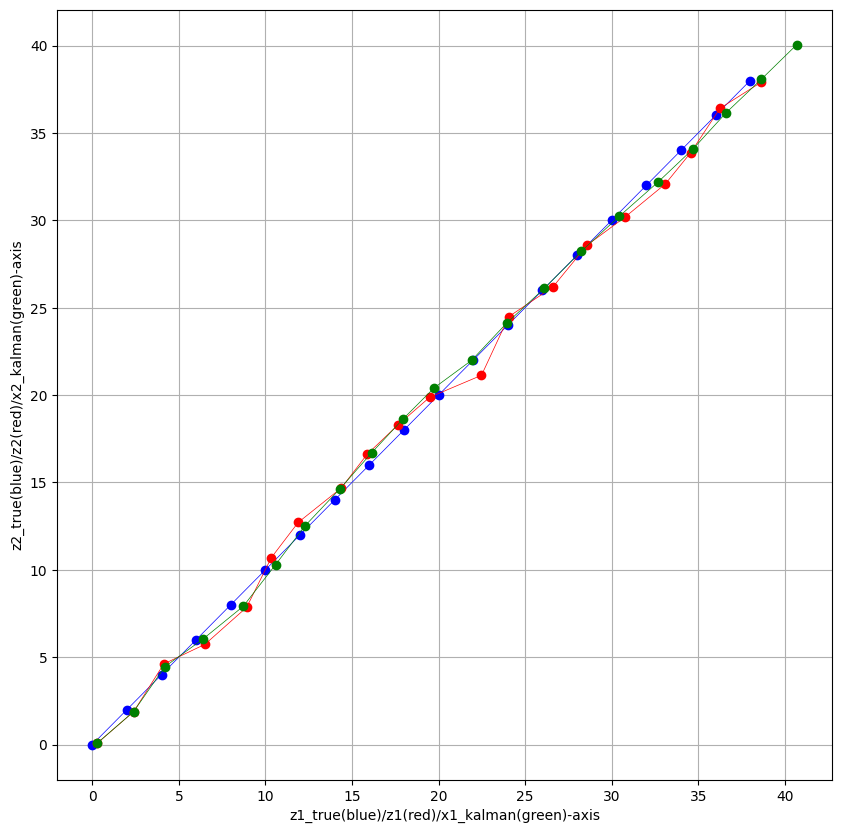

In [10]:
#plot creation
plot_creator(z, z_true, x_plus_list)

In [11]:
#table creation
table_printer(k_upper, x_noise, z_noise, z_true, x_plus_list, P_minus_list, P_plus_list)

k || x_k,1-noise | x_k,2-noise | x_k,3-noise | x_k,4-noise | z_k,1-noise | z_k,2-noise |
----------------------------------------------------------------------------------------
1 ||   -0.0008   ||   0.0198   ||   0.0123   ||   0.2783   ||   0.2784   ||   0.2784
2 ||   -0.0041   ||   0.0102   ||   0.0804   ||   0.3972   ||   0.3931   ||   0.3931
3 ||   -0.0081   ||   0.005   ||   -0.0551   ||   -0.0998   ||   0.1307   ||   0.1307
4 ||   -0.0204   ||   -0.0002   ||   -0.4824   ||   0.1173   ||   0.5105   ||   0.5105
5 ||   0.0157   ||   -0.02   ||   0.2857   ||   -0.5402   ||   0.9372   ||   0.9372
6 ||   0.0054   ||   0.0008   ||   0.2565   ||   -0.2174   ||   0.3902   ||   0.3902
7 ||   0.0196   ||   0.0044   ||   0.441   ||   0.1074   ||   -0.0515   ||   -0.0515
8 ||   -0.0054   ||   -0.0153   ||   -0.0348   ||   -0.3062   ||   0.4119   ||   0.4119
9 ||   0.0097   ||   -0.0126   ||   0.1055   ||   -0.159   ||   -0.1452   ||   -0.1452
10 ||   0.0107   ||   -0.0104   ||   0.3259   ||  